# Imports

In [1]:
import sys
import os
import cv2
import io
import imageio
from src.data import CS_VideoData 
from src.futurist import Futurist
import argparse
import torch
import pytorch_lightning as pl
import os
import matplotlib.cm as cm
import glob
import os.path as osp
from tqdm import tqdm
import numpy as np
from PIL import Image
import yaml
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import einops
import torch.nn as nn
IGNORE_LABEL = 255

/home/ubuntu/anaconda3/envs/fpred/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Args

# Configure your data path

In [3]:
args = argparse.Namespace()
args.data_path = "/home/ubuntu/cityscapes/leftImg8bit_sequence_segmaps_ids"
args.dst_path = None
args.num_workers = 1
args.num_workers_val = 1
args.sequence_length = 5
args.batch_size = 1
args.shape = (1024, 2048)
args.downsample_factor = 4
args.random_crop = True
args.random_horizontal_flip = True
args.random_time_flip = False
args.timestep_augm = None
args.no_timestep_augm = False
args.modality = 'segmaps_depth'
args.use_fc_bias = False
args.num_classes = 19
args.hidden_dim = 1536
args.heads = 8
args.layers = 12
args.dropout = 0.1
args.patch_size = 16
args.loss_type = 'CE'
args.attn_dropout = 0.3
args.accum_iter = 1
args.step = 1
args.masking = 'simple_replace'
args.masking_strategy = "par_shared_excl"
args.modal_fusion="concat"
args.train_mask_mode = 'arccos'
args.seperable_attention = True
args.seperable_window_size = 1
args.train_mask_frames = 1
args.use_first_last = False
args.emb_dim = [10,10]
args.w_s = 0.5
args.sep_head = False
args.max_epochs = 135
args.seed = 123
args.start_frame_loss = None
args.precision = "16-true"
args.ckpt = None
args.num_gpus = 1
args.lr_base = 1e-3
args.gclip = 1.0
args.evaluate = True
args.vis_attn = False
args.eval_last = False
args.eval_ckpt_only = False
args.eval_mode_during_training = True
args.eval_freq = 1
args.use_val_to_train = False
args.use_train_to_val = False
args.evaluate_baseline = False
args.eval_midterm = False
args.eval_mode = True

obj_colors_dict = {
    0: [128, 64, 128],
    1: [244, 35, 232],
    2: [70, 70, 70],
    3: [102, 102, 156],
    4: [190, 153, 153],
    5: [153, 153, 153],
    6: [250, 170, 30],
    7: [220, 220, 0],
    8: [107, 142, 35],
    9: [152, 251, 152],
    10: [70, 130, 180],
    11: [220, 20, 60],
    12: [255, 0, 0],
    13: [0, 0, 142],
    14: [0, 0, 70],
    15: [0, 60, 100],
    16: [0, 80, 100],
    17: [0, 0, 230],
    18: [119, 11, 32]
}
args.class_colors_arr = np.array(list(obj_colors_dict.values()),dtype=np.uint8)
args.device = 'cuda'

# Data loader and model load

In [4]:
dataset = CS_VideoData(arguments=args,subset="val",batch_size=args.batch_size)
val_dl = dataset.val_dataloader()

In [5]:
ckpt_path = "/home/ubuntu/Fpred_logs/Segm_Depth/futurist.ckpt"
model = Futurist.load_from_checkpoint(ckpt_path,args=args,strict=False).to(args.device)
model.eval()

/home/ubuntu/anaconda3/envs/fpred/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['maskvit.fc_out.bias']


Futurist(
  (emb_s): Embedding(19, 10)
  (emb_d): Embedding(256, 10)
  (maskvit): MaskTransformer(
    (pos_embd): AddBroadcastPosEmbed(
      (emb): ParameterDict(
          (d_0): Parameter containing: [torch.cuda.FloatTensor of size 5x512 (cuda:0)]
          (d_1): Parameter containing: [torch.cuda.FloatTensor of size 16x512 (cuda:0)]
          (d_2): Parameter containing: [torch.cuda.FloatTensor of size 32x512 (cuda:0)]
      )
    )
    (first_layer): Identity()
    (transformer): TransformerEncoderSeperableAttention(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0-1): 2 x PreNorm(
            (norm): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (mha): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=1536, out_features=1536, bias=True)
              )
            )
          )
          (2): PreNorm(
            (norm): LayerNorm((1536,), eps=1e-05, elementwise

# Data Loading and Visualization

Use batch_size=1 for visualizations

In [6]:
s = 0 # Select which scene to visualize
for i, batch in enumerate(val_dl):
    data, gt_segm, gt_depth = batch
    if i == s:
        break
print(data.shape)
print(gt_segm.shape)
vis_gt_segm = np.zeros((args.shape[0],args.shape[1],3),dtype=np.uint8)
mask = gt_segm.squeeze()!=IGNORE_LABEL
vis_gt_segm[mask,:] =  args.class_colors_arr[gt_segm.squeeze()[mask]]

torch.Size([1, 5, 2, 256, 512])
torch.Size([1, 1024, 2048])


### Visualize an image and the gt from the sequence

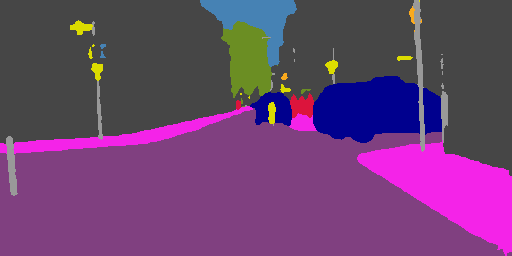

In [7]:
Num_frame = 4  # 0-sequence_length
segm_idx = 0
T.ToPILImage(mode='RGB')(args.class_colors_arr[data[0][Num_frame][segm_idx]]) # Oracle Segmentation

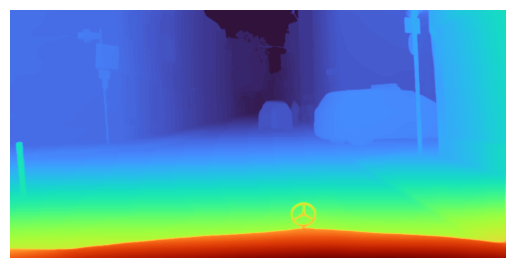

In [8]:
frame = 4
depth_image = data[0, frame][1].squeeze().cpu().numpy()
plt.imshow(depth_image, cmap='turbo')
plt.axis('off')
plt.show()

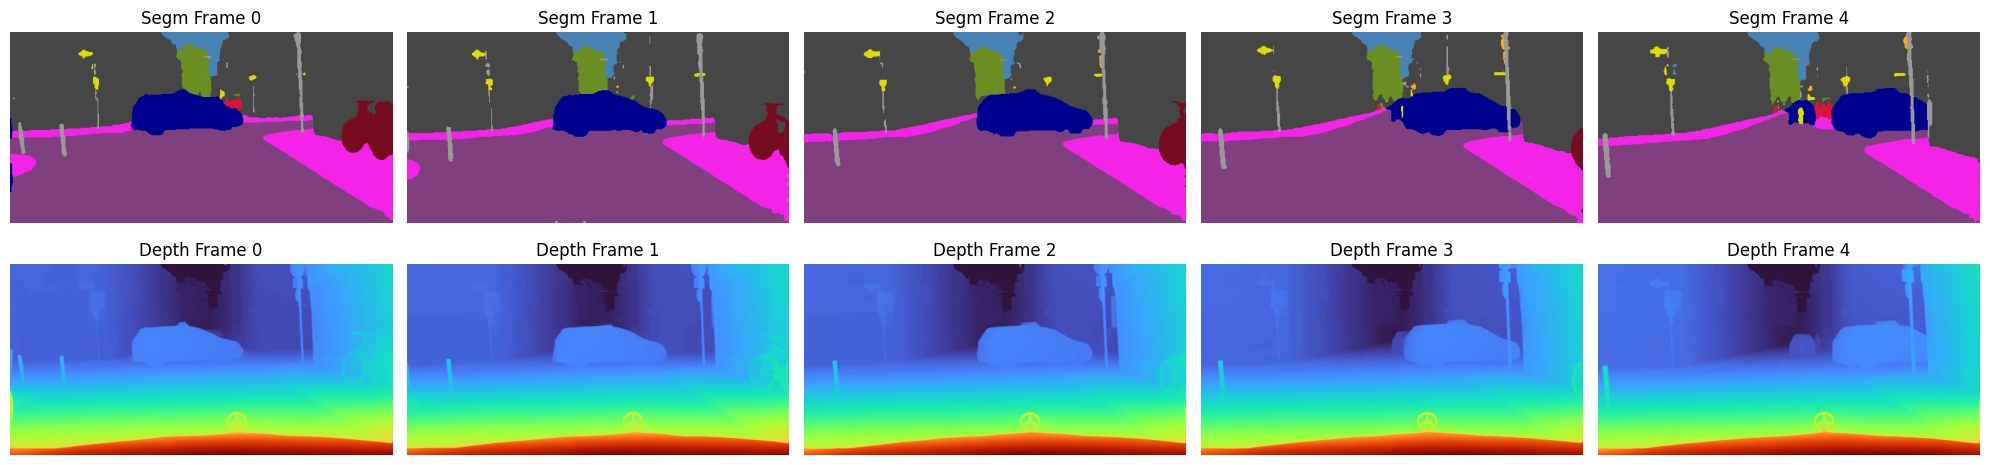

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=args.sequence_length, figsize=(20, 5))
for i in range(args.sequence_length):
    axes[0, i].imshow(args.class_colors_arr[data[0][i][0]])
    axes[0, i].set_title(f"Segm Frame {i}")
    axes[0, i].axis('off')
    axes[1, i].imshow(data[0][i][1],cmap='turbo')
    axes[1, i].set_title(f"Depth Frame {i}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

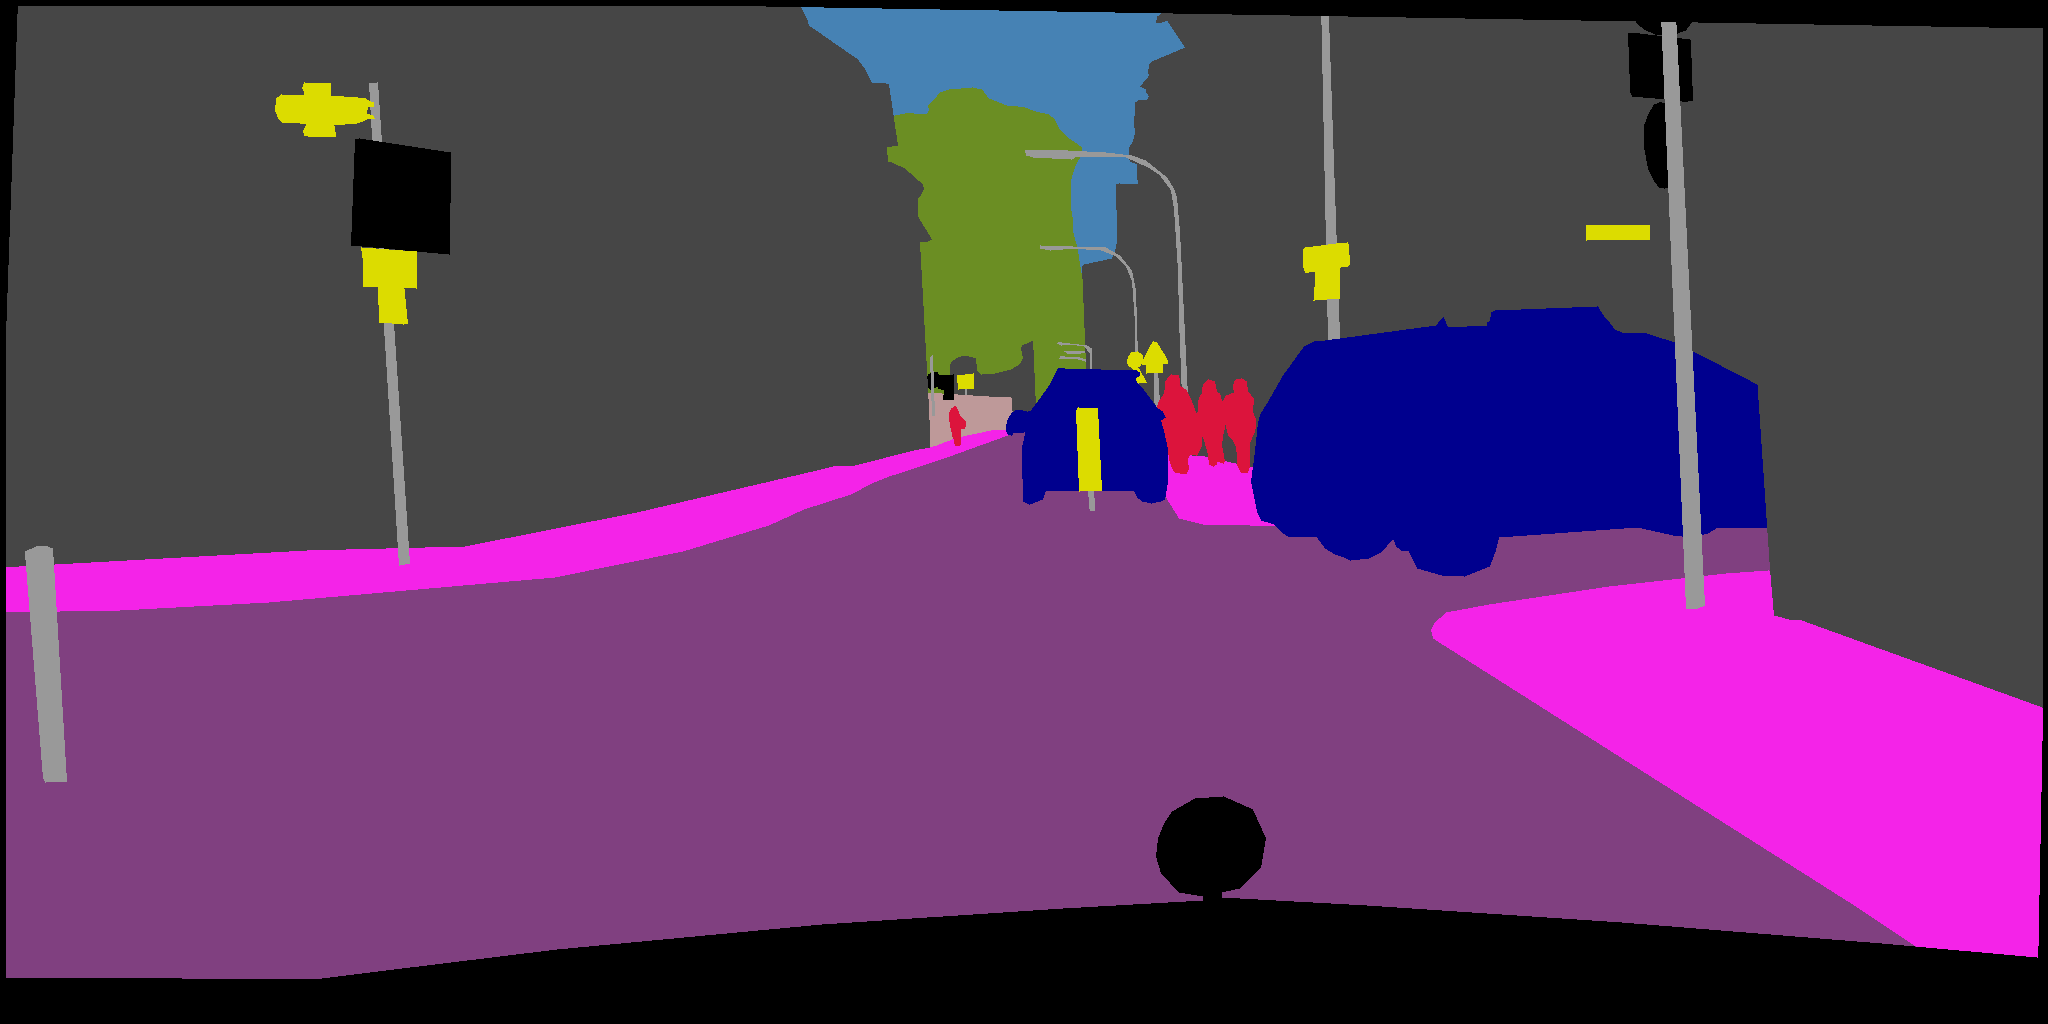

In [10]:
data.shape
T.ToPILImage(mode='RGB')(vis_gt_segm)

# Forward Pass 

tensor(1.2857, device='cuda:0')
torch.Size([1, 5, 275, 256, 512])
torch.Size([256, 512])
torch.Size([256, 512])


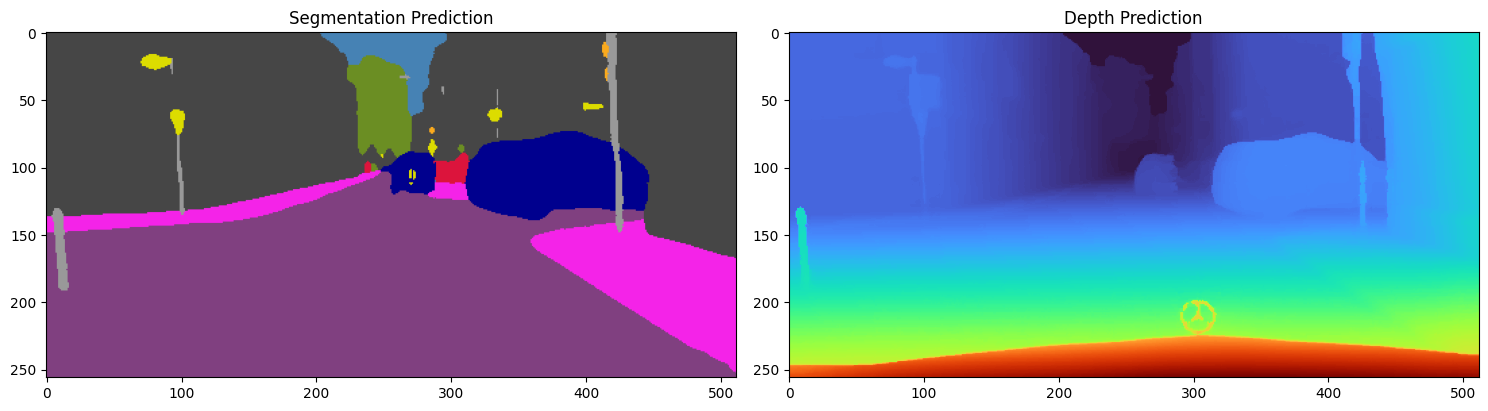

In [13]:
with torch.no_grad():
    x, x_oracle =  model.preprocess(data.to(args.device))
    masked_x, mask = model.get_mask_tokens(x, mode="full_mask")
    if args.vis_attn:
        loss, means, attn_weights = model.forward(x, masked_x, mask, x_oracle)
    else:
        loss, means, = model.forward(x, masked_x, mask, x_oracle)
print(loss)
prediction = model.decode(means)
print(prediction.shape)
samples_segm = prediction[:,-1,:19].squeeze(0).argmax(0)
samples_depth = prediction[:,-1,19:].squeeze(0).argmax(0)
print(samples_segm.shape)
print(samples_depth.shape)
pred_segm_rgb = args.class_colors_arr[samples_segm.cpu()]
# Plot segmentation prediction
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Segmentation Prediction")
plt.imshow(pred_segm_rgb)
# Plot depth prediction
plt.subplot(1, 2, 2)
plt.title("Depth Prediction")
plt.imshow(samples_depth.to(dtype=torch.uint8).cpu(), cmap='turbo')
plt.tight_layout()
plt.show()

/tmp/ipykernel_868915/1000575952.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('turbo')


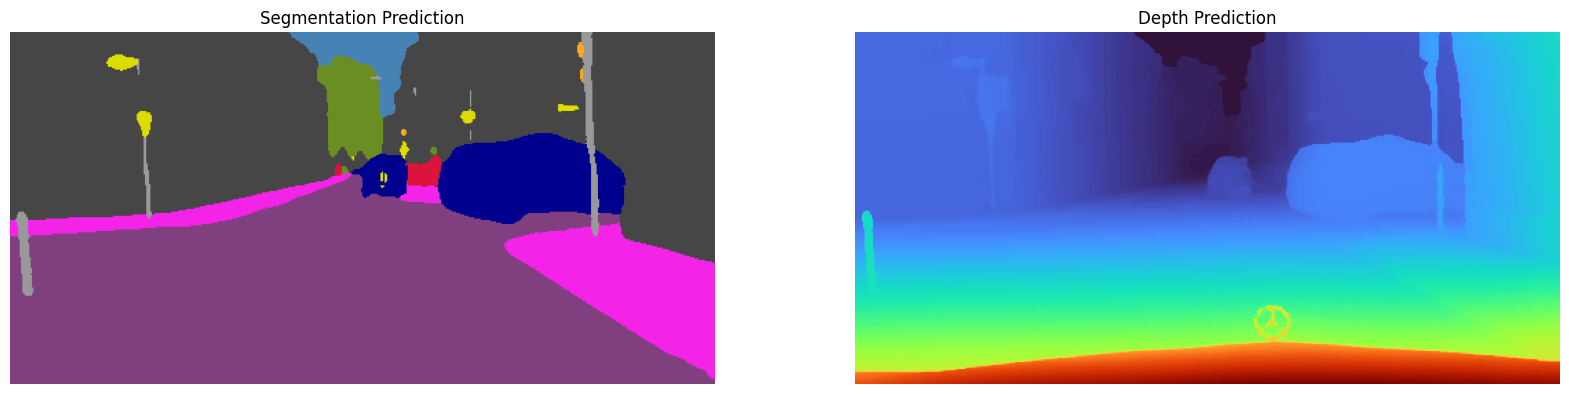

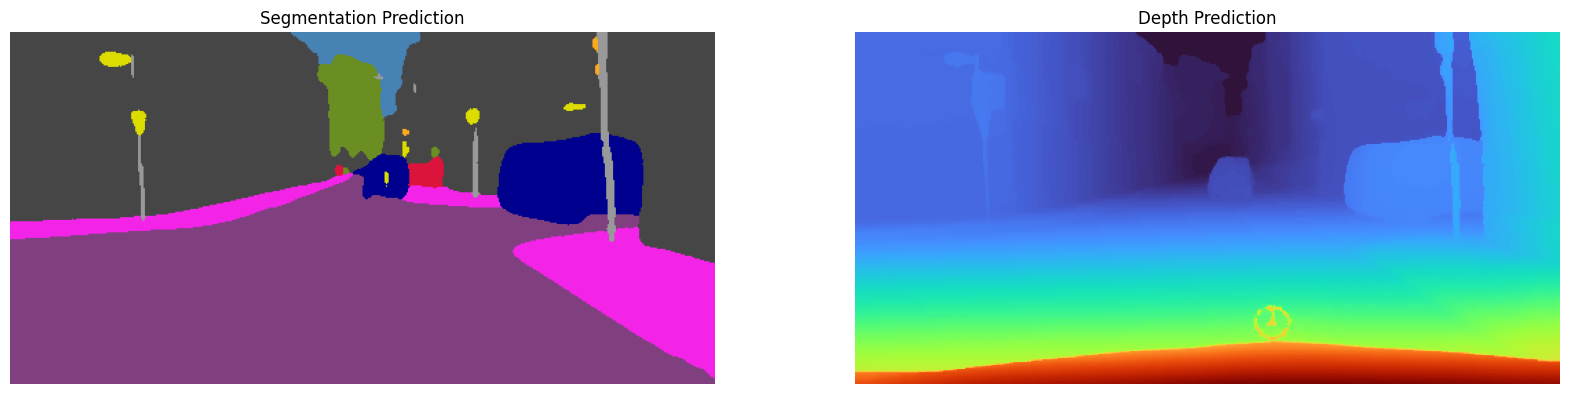

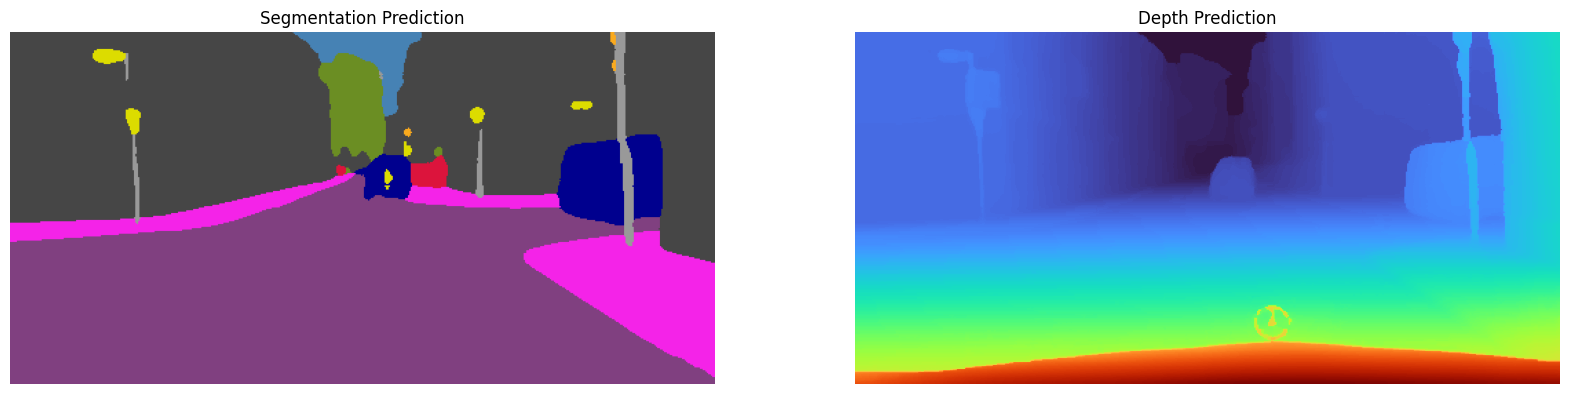

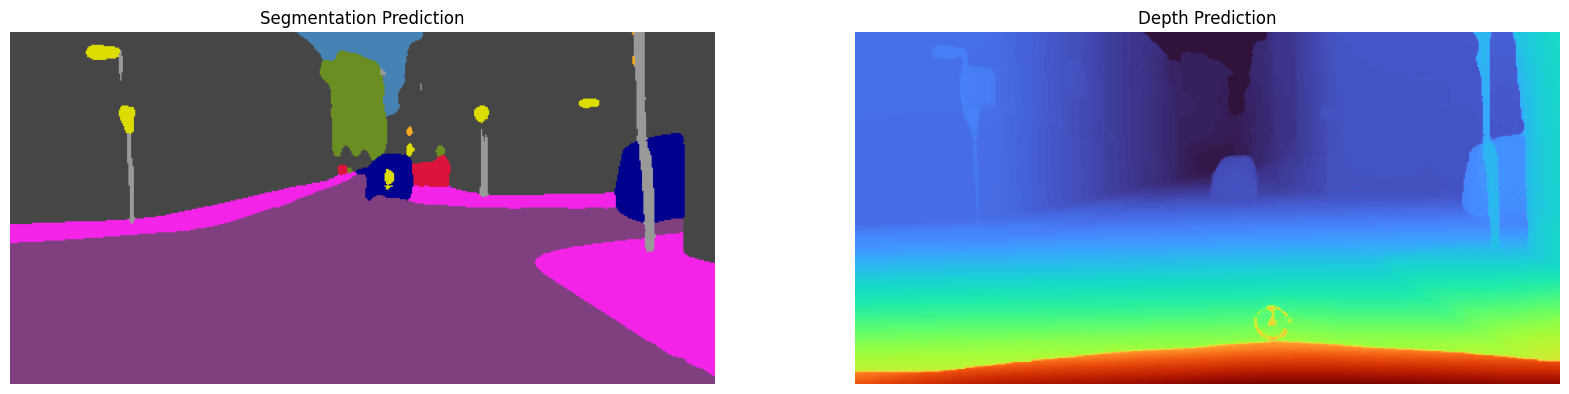

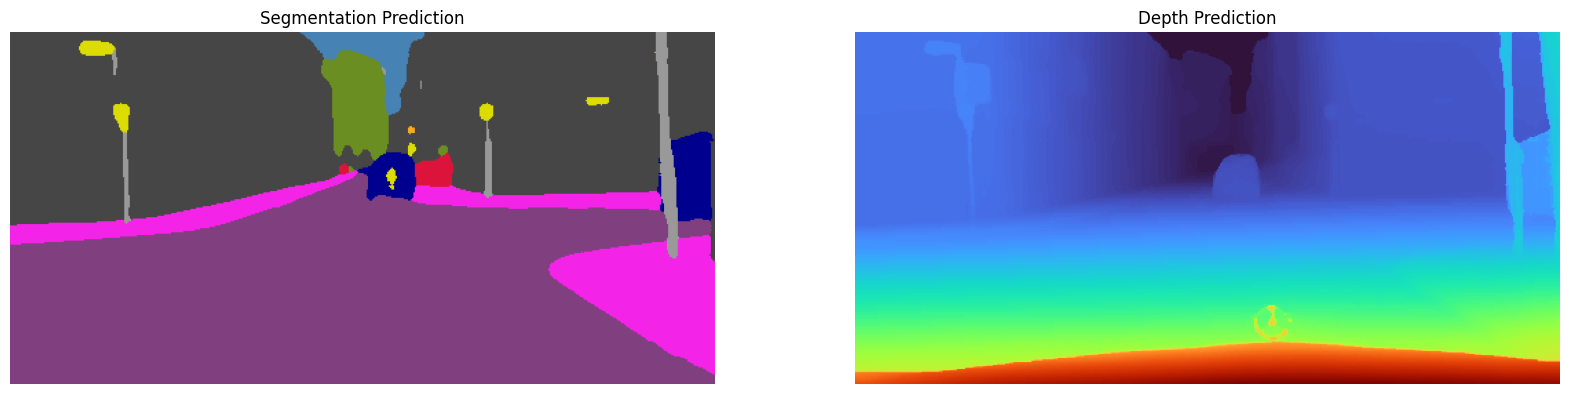

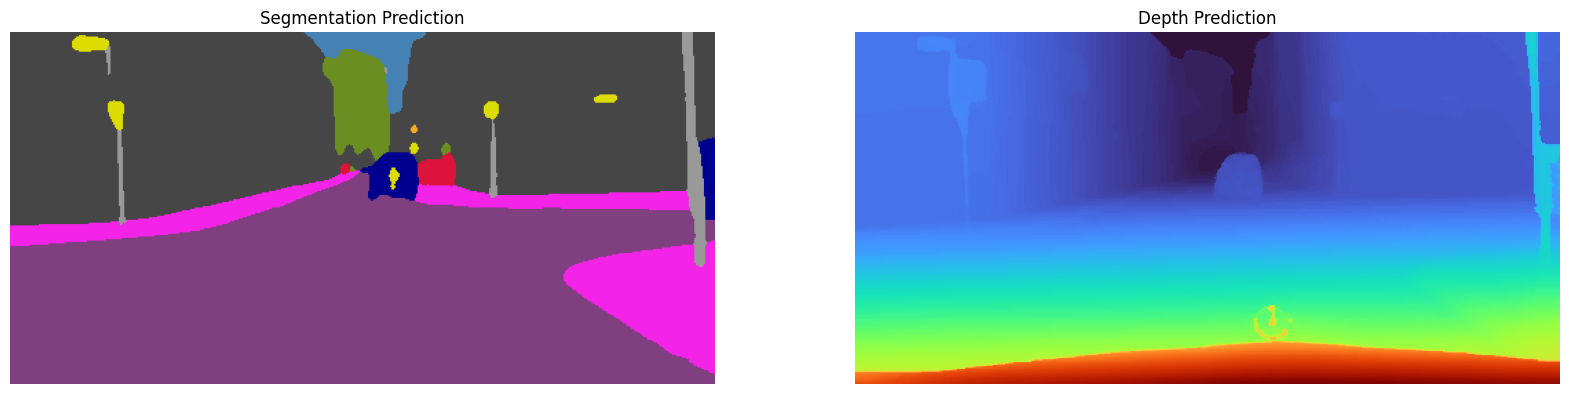

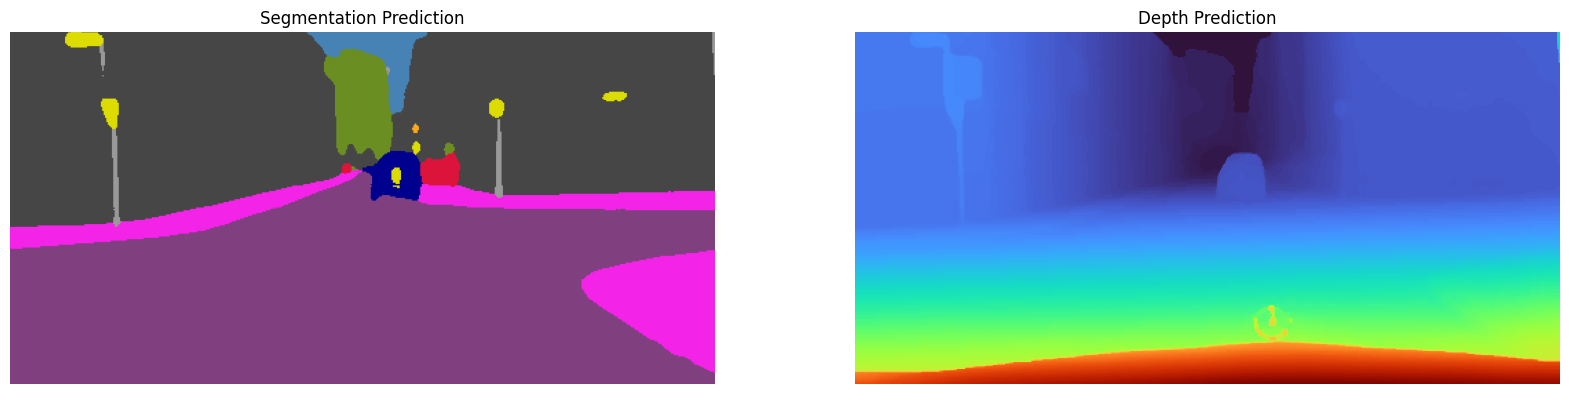

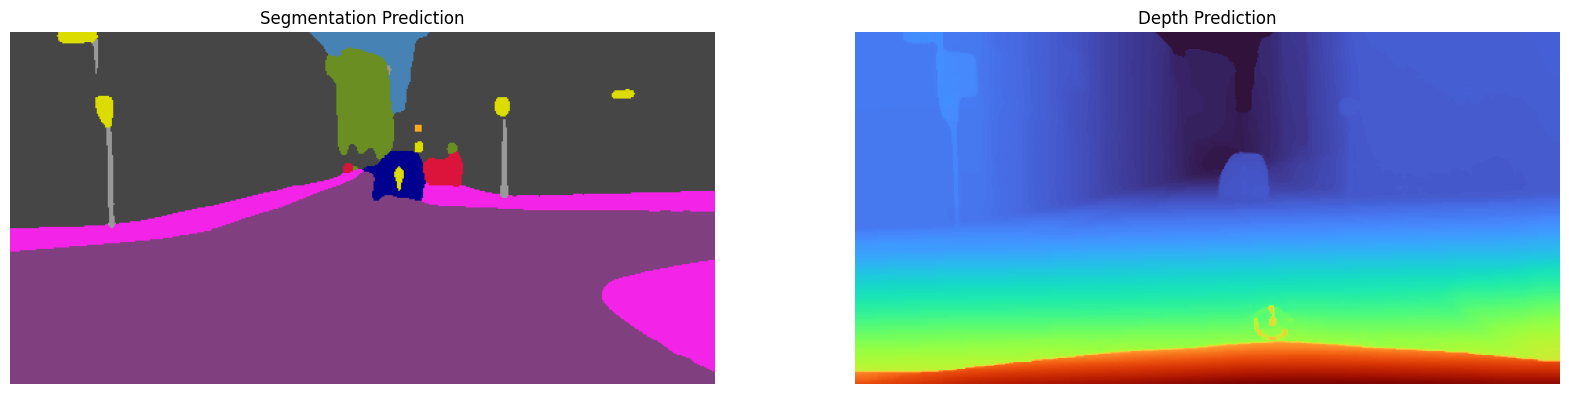

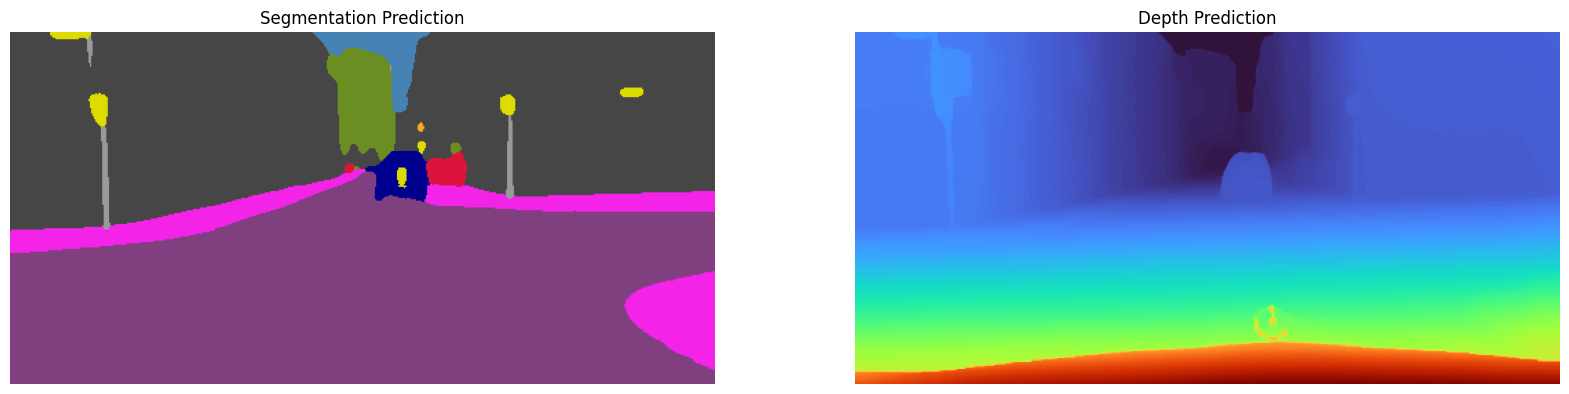

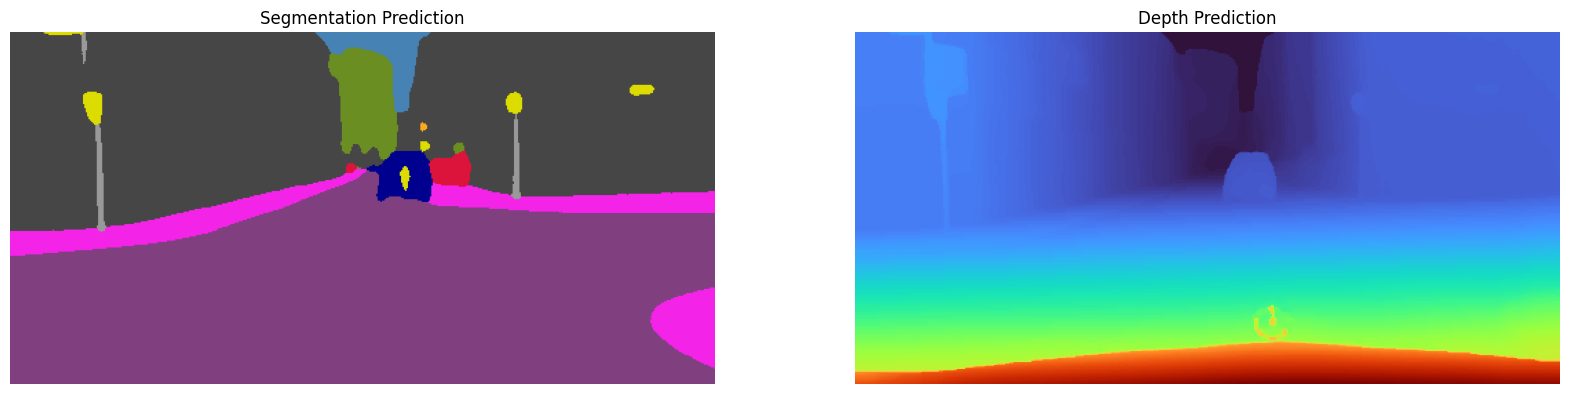

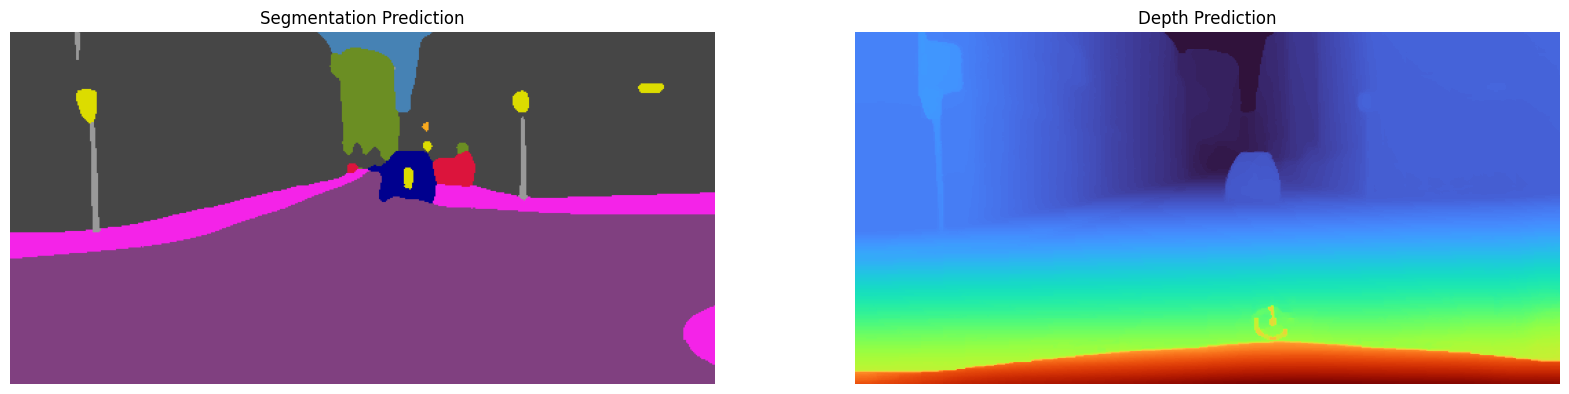

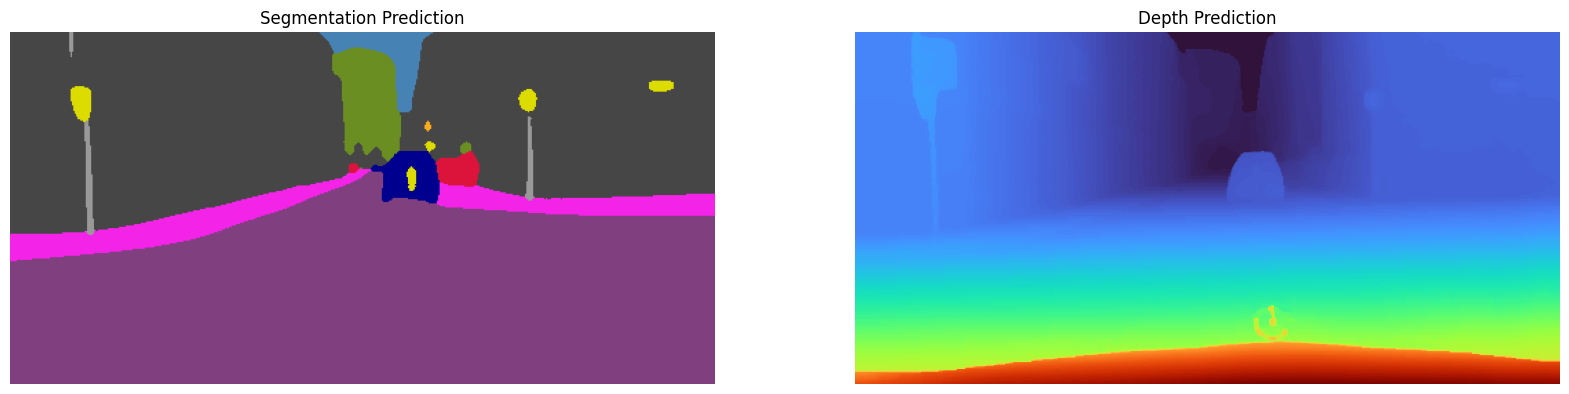

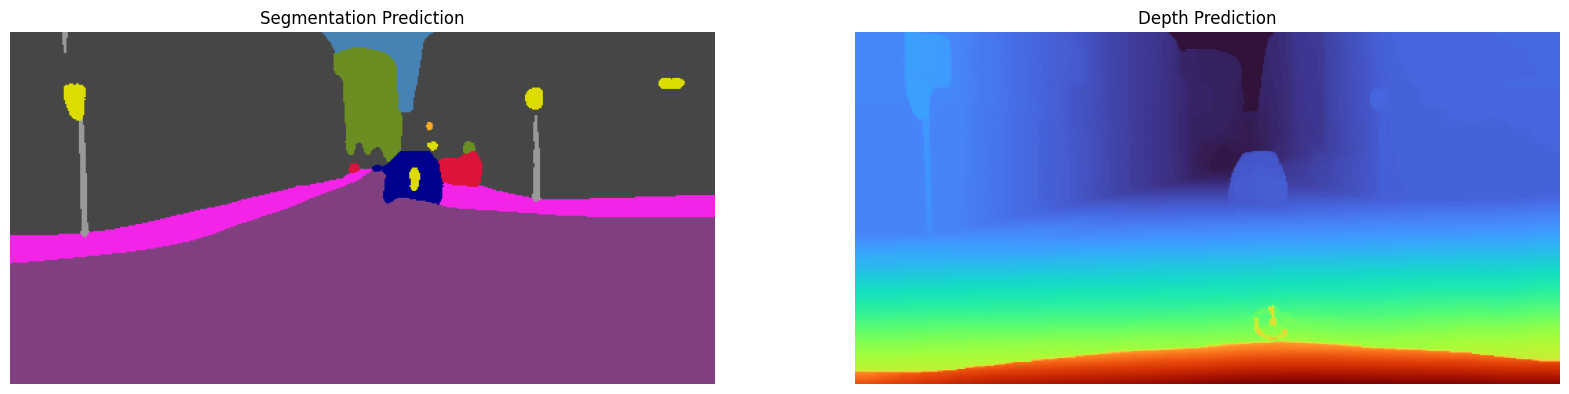

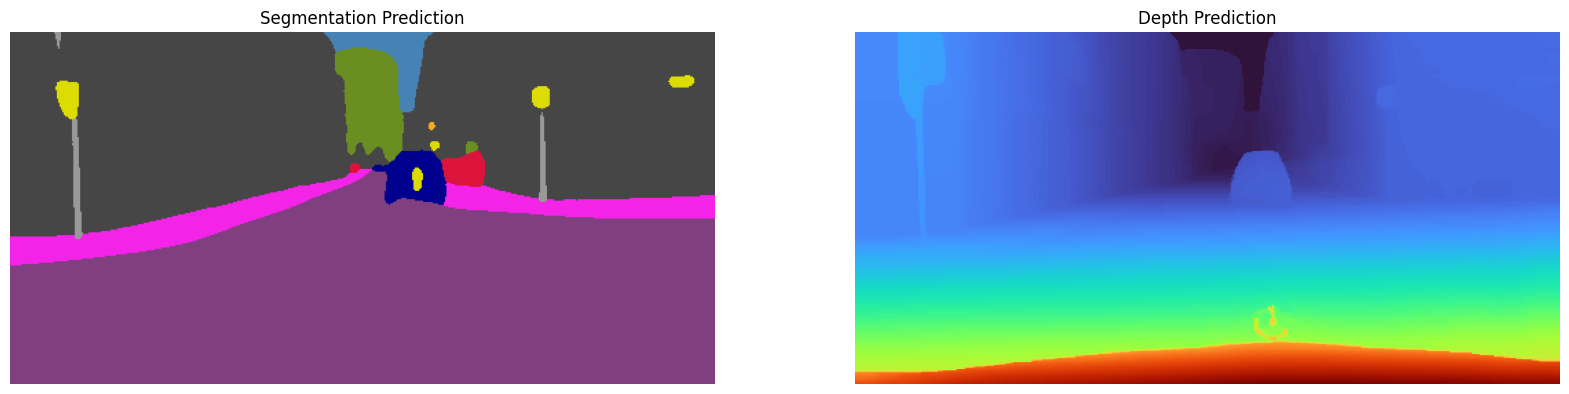

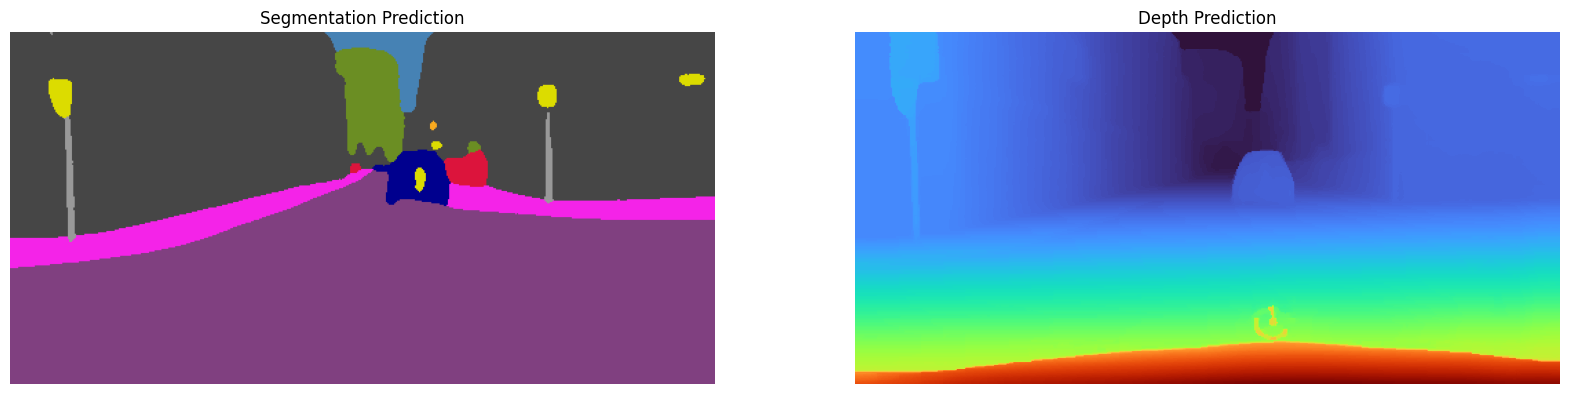

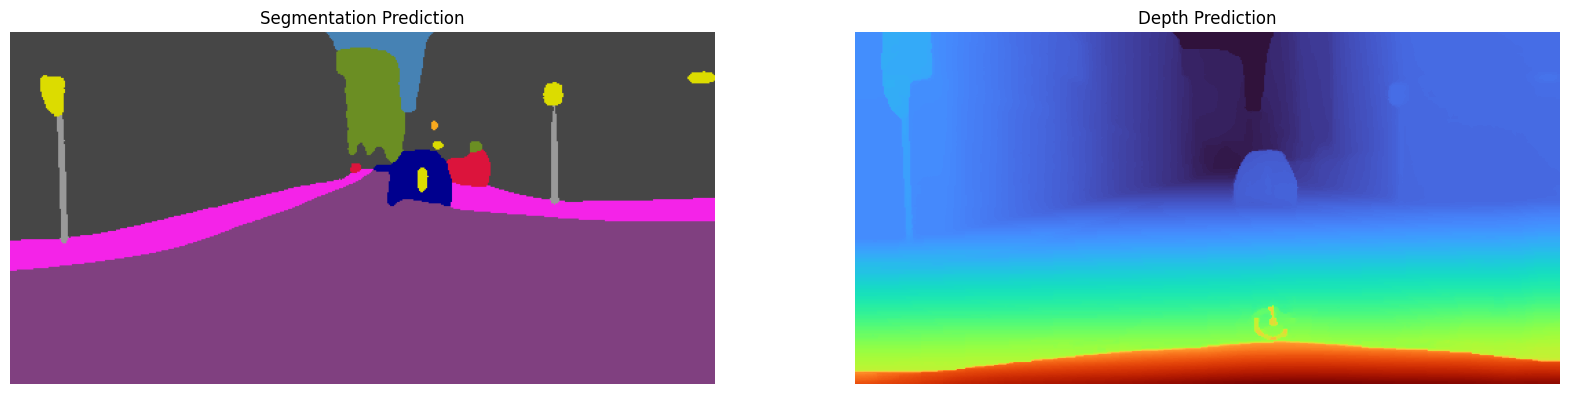

In [17]:
    unroll_steps = 16 # 2.5 sec
    data_tu = data.clone()
    for i in range(unroll_steps):
        with torch.no_grad():
            x, x_oracle = model.preprocess(data_tu.to(args.device))
            masked_x, mask = model.get_mask_tokens(x, mode="full_mask")
            if args.vis_attn:
                loss, means, attn_weights = model.forward(x, masked_x, mask, x_oracle)
            else:
                loss, means, = model.forward(x, masked_x, mask, x_oracle)
        prediction = model.decode(means)
        samples_segm = prediction[:,-1,:19].squeeze(0).argmax(0)
        samples_depth = prediction[:,-1,19:].squeeze(0).argmax(0)
        pred_segm_rgb = args.class_colors_arr[samples_segm.cpu()]
        fig, axes = plt.subplots(1, 2, figsize=(20, 5))
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            fig.patch.set_visible(False)
        axes[0].imshow(T.ToPILImage(mode='RGB')(pred_segm_rgb))
        axes[0].axis("off")
        axes[0].set_title("Segmentation Prediction")
        
        axes[1].imshow(samples_depth.cpu().numpy(), cmap='turbo')
        axes[1].axis("off")
        axes[1].set_title("Depth Prediction")
        # Apply colormap
        colormap = cm.get_cmap('turbo')
        depth_image_colored = colormap(samples_depth.to(dtype=torch.uint8).cpu().numpy())[:,:,:-1]
        # plt.tight_layout()
        # plt.show()
        data_tu[:,-1] = torch.cat([samples_segm.unsqueeze(0), samples_depth.unsqueeze(0)], dim=0).unsqueeze(0)
        data_tu[:,0:-1] = data_tu[:,1:].clone()